In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
import warnings            
warnings.filterwarnings("ignore")

In [2]:
def prepare_data():
    # verinin okunması
    data = pd.read_csv('M30_EURUSD.csv',low_memory=False)
    # soru işaretleri olan satırlar veriden silindi.
    data = data.replace("?", np.nan)
    data = data.dropna()
    # verinin feature larının ayrılması
    df = data.iloc[:,5:430]
    df_first = data.iloc[:,1:5]
    df_result = data.iloc[:,430:-1]
    return df, df_first, df_result

In [3]:
# parametrik fonk. tanımlaması
# 1 : 
# 2 :

def kategorikleri_dummy_yap(df):
    cat_column_names = ['ind_7','ind_11','ind_24','ind_38','ind_54','ind_57','ind_60','ind_63','ind_66','ind_69','ind_72','ind_75',
                    'ind_78','ind_81','ind_84','ind_87','ind_89','ind_91','ind_93','ind_95','ind_97','ind_99','ind_101',
                    'ind_103','ind_105','ind_107','ind_109', 'ind_111', 'ind_113', 'ind_115','ind_138','ind_141','ind_144',
                    'ind_157','ind_159','ind_161','ind_163','ind_165','ind_167','ind_169','ind_171','ind_173','ind_175',
                    'ind_177','ind_182','ind_184','ind_187','ind_190','ind_193','ind_196','ind_199','ind_202','ind_205',
                    'ind_208','ind_211','ind_213','ind_384','ind_386','ind_388','ind_390']
    # categorical kolonların dummy var. oalrak değiştirdik
    dms = pd.get_dummies(df[cat_column_names])
    dms_none_cols = dms.filter(regex = '_NONE').columns
    for i in dms_none_cols:
        dms.drop(i,axis=1,inplace=True)
    dms_red_cols = dms.filter(regex = '_RED').columns
    for i in dms_red_cols:
        dms.drop(i,axis=1,inplace=True)
    #datadan categorical olan kolonları çıkarıyoruz ve type nı değiştiriyoruz
    df_noncategoric = df.drop(cat_column_names,axis=1).astype("float64")
    df_all = pd.concat([df_noncategoric, dms], axis=1)
    # y değerlerinin alınması
    return df_all, df_noncategoric, dms

In [4]:
# 1.1 - dropping correlaritions
def corr_df(df, corr_val):
    corr_matrix = df_noncategoric.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_high = [column for column in upper.columns if any(upper[column] > corr_val)]
    df.drop(to_high, axis = 1, inplace = True)
    return df

In [5]:
# 1.2 RandomForest
# bütün değişkenlerle yapılan random forest sonucu importance değeri verilen parametreden büyük olan değişkenleri döner
def rand_forest(X, y, imp_value):
    rf_model = RandomForestClassifier().fit(X, y)
    Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, index = X.columns)
    imp_values = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)
    imp_values = imp_values[imp_values['Importance']>imp_value]
    col_names = imp_values.index   
    return X[col_names]

In [6]:
# 1.3 - pca
def pca_fon(X, threshold):
    pca = PCA()
    X_pca = pca.fit_transform(scale(X))
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = X.index)
    return X_pcad

In [7]:
def splitting(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    return X_train, X_test, y_train, y_test

In [8]:
# 2.1.1 - multi lojistik
def multi_logit(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
    log = logreg.fit(X_train, y_train)
    y_pred = log.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [9]:
# 2.1.2 - decision tree
def dec_tree(X_train, X_test, y_train, y_test):
    cart = DecisionTreeClassifier()
    cart_model = cart.fit(X_train, y_train)
    y_pred = cart_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [10]:
def grad_boost(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import GradientBoostingClassifier
    print('grad_boost----------------')
    gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
    y_pred = gbm_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [11]:
def xgb_boost(X_train, X_test, y_train, y_test):
    from xgboost import XGBClassifier
    print('xgb_boost----------------')
    xgb_model = XGBClassifier().fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [12]:
def lightGBM(X_train, X_test, y_train, y_test):
    from lightgbm import LGBMClassifier
    print('lightGBM----------------')
    lgbm_model = LGBMClassifier(verbose=-1).fit(X_train,y_train)    
    y_pred = lgbm_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [13]:
def catBoost(X_train, X_test, y_train, y_test):
    from catboost import CatBoostClassifier
    print('CatBoost----------------')
    cat_model = CatBoostClassifier().fit(X_train, y_train)
    y_pred = cat_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [14]:
# 2.1.3 - Boosting
def boostings(X_train, X_test, y_train, y_test):
    grad_boost(X_train, X_test, y_train, y_test)
    xgb_boost(X_train, X_test, y_train, y_test)
    # lightGBM(X_train, X_test, y_train, y_test)
    # catBoost(X_train, X_test, y_train, y_test)

In [15]:
# 2.1.2 - decision tree
def dec_tree_withcv(X_train, X_test, y_train, y_test):
    cart = DecisionTreeClassifier()
    cart_model = cart.fit(X_train, y_train)
    y_pred = cart_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [16]:
# verinin okunması - df: ilk 5 kolon ve result'lar hariç kolonlar, df_first: ilk 5 kolon, df_result: sonuç kolonları
df, df_first, df_result = prepare_data()

In [17]:
# y sütunlarında geçen verilerden en çok tekrar edenler y sütunu olarak alınmıştır.
# desc = y.T.describe(include='all')
y_max1 = df_result.mode(axis=1)
y = pd.DataFrame(y_max1[0])
y.head()

,0
2001,BUY
2002,BUY
2003,BUY
2004,BUY
2005,BUY


In [18]:
# 1.1 den gelen veriler (non correlatedlardan gelenler)
df_all, df_noncategoric, dms = kategorikleri_dummy_yap(df)
df_noncorr = corr_df(df_noncategoric, 0.50)
X1_1 = pd.concat([df_first, df_noncorr, dms], axis=1)


In [19]:
# 1.2 den gelen veriler. 
# Notlar: 
# 1 - y için iterasyon denenebilir. y kolonu '220_signal' seçilmiştir.
# 2- importance treshold'u 0.05 seçilmiştir, cv yapılabilir.

X_raw = pd.concat([df_first,df_all], axis=1) 
X1_2 = rand_forest(X_raw, y, 0.05)    

In [20]:
# 1.3 den gelen veriler.
X_raw2 = pd.concat([df_first,df_all], axis=1) 
X1_3 = pca_fon(X_raw2, 0.99)
X_raw2.shape, X1_3.shape

pca sonrası değişken sayısı:  191


((19901, 486), (19901, 191))

In [21]:
X_train1, X_test1, y_train, y_test = splitting(X1_1, y, 0.10)
print('X1_1 için multi log')
multi_logit(X_train1, X_test1, y_train, y_test)
print('*************************************************************************************')

X1_1 için multi log
Accuracy:  0.4153691612255148
-------------------------------
Counfusion matrix: 
 [[293   0 201]
 [197   0 119]
 [647   0 534]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.26      0.59      0.36       494
        NONE       0.00      0.00      0.00       316
        SELL       0.63      0.45      0.52      1181

    accuracy                           0.42      1991
   macro avg       0.29      0.35      0.29      1991
weighted avg       0.43      0.42      0.40      1991

*************************************************************************************


In [22]:
X_train2, X_test2, y_train, y_test = splitting(X1_2, y, 0.10)
print('X1_2 için multi log')
multi_logit(X_train2, X_test2, y_train, y_test)
print('*************************************************************************************')

X1_2 için multi log
Accuracy:  0.38623807132094423
-------------------------------
Counfusion matrix: 
 [[331   3 160]
 [238  12  66]
 [735  20 426]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.25      0.67      0.37       494
        NONE       0.34      0.04      0.07       316
        SELL       0.65      0.36      0.46      1181

    accuracy                           0.39      1991
   macro avg       0.42      0.36      0.30      1991
weighted avg       0.50      0.39      0.38      1991

*************************************************************************************


In [23]:
X_train3, X_test3, y_train, y_test = splitting(X1_3, y, 0.10)
print('X1_3 için multi log')
multi_logit(X_train3, X_test3, y_train, y_test)
print('*************************************************************************************')

X1_3 için multi log
Accuracy:  0.3219487694625816
-------------------------------
Counfusion matrix: 
 [[362   4 128]
 [248  19  49]
 [848  73 260]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.25      0.73      0.37       494
        NONE       0.20      0.06      0.09       316
        SELL       0.59      0.22      0.32      1181

    accuracy                           0.32      1991
   macro avg       0.35      0.34      0.26      1991
weighted avg       0.45      0.32      0.30      1991

*************************************************************************************


In [24]:
X_train1, X_test1, y_train, y_test = splitting(X1_1, y, 0.10)
print('X1_1 için dec tree')
dec_tree(X_train1, X_test1, y_train, y_test)
print('*************************************************************************************')

X1_1 için dec tree
Accuracy:  0.29884480160723254
-------------------------------
Counfusion matrix: 
 [[164  90 240]
 [138  78 100]
 [425 403 353]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.23      0.33      0.27       494
        NONE       0.14      0.25      0.18       316
        SELL       0.51      0.30      0.38      1181

    accuracy                           0.30      1991
   macro avg       0.29      0.29      0.27      1991
weighted avg       0.38      0.30      0.32      1991

*************************************************************************************


In [25]:
X_train2, X_test2, y_train, y_test = splitting(X1_2, y, 0.10)
print('X1_2 için dec tree')
dec_tree(X_train2, X_test2, y_train, y_test)
print('*************************************************************************************')

X1_2 için dec tree
Accuracy:  0.27122049221496736
-------------------------------
Counfusion matrix: 
 [[345  85  64]
 [275  36   5]
 [663 359 159]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.27      0.70      0.39       494
        NONE       0.07      0.11      0.09       316
        SELL       0.70      0.13      0.23      1181

    accuracy                           0.27      1991
   macro avg       0.35      0.32      0.23      1991
weighted avg       0.49      0.27      0.24      1991

*************************************************************************************


In [26]:
X_train3, X_test3, y_train, y_test = splitting(X1_3, y, 0.10)
for i in y.columns:
    print(i, ' kolonu için sonuçlar:')
    dec_tree(X_train3, X_test3, y_train[i], y_test[i])
    print('*************************************************************************************')

0  kolonu için sonuçlar:
Accuracy:  0.3751883475640382
-------------------------------
Counfusion matrix: 
 [[237  46 211]
 [141  35 140]
 [564 142 475]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.25      0.48      0.33       494
        NONE       0.16      0.11      0.13       316
        SELL       0.58      0.40      0.47      1181

    accuracy                           0.38      1991
   macro avg       0.33      0.33      0.31      1991
weighted avg       0.43      0.38      0.38      1991

*************************************************************************************


In [27]:
X_train1, X_test1, y_train, y_test = splitting(X1_1, y, 0.30)
for i in y.columns:
    print(i, ' kolonu için sonuçlar:')
    boostings(X_train1, X_test1, y_train[i], y_test[i])
    print('*************************************************************************************')

0  kolonu için sonuçlar:
grad_boost----------------
Accuracy:  0.34433093284207
-------------------------------
Counfusion matrix: 
 [[1929   54   40]
 [1151    2   82]
 [2583    5  125]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.34      0.95      0.50      2023
        NONE       0.03      0.00      0.00      1235
        SELL       0.51      0.05      0.08      2713

    accuracy                           0.34      5971
   macro avg       0.29      0.33      0.20      5971
weighted avg       0.35      0.34      0.21      5971

xgb_boost----------------
Accuracy:  0.3481828839390387
-------------------------------
Counfusion matrix: 
 [[1996    0   27]
 [1154    0   81]
 [2630    0   83]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.35      0.99      0.51      2023
        NONE       0.00      0.00      0.00      1

In [28]:
X_train2, X_test2, y_train, y_test = splitting(X1_2, y, 0.30)
for i in y.columns:
    print(i, ' kolonu için sonuçlar:')
    boostings(X_train2, X_test2, y_train[i], y_test[i])
    print('*************************************************************************************')

0  kolonu için sonuçlar:
grad_boost----------------
Accuracy:  0.36911740077039024
-------------------------------
Counfusion matrix: 
 [[1843    9  171]
 [1118    0  117]
 [2348    4  361]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.35      0.91      0.50      2023
        NONE       0.00      0.00      0.00      1235
        SELL       0.56      0.13      0.21      2713

    accuracy                           0.37      5971
   macro avg       0.30      0.35      0.24      5971
weighted avg       0.37      0.37      0.27      5971

xgb_boost----------------
Accuracy:  0.4086417685479819
-------------------------------
Counfusion matrix: 
 [[1730    0  293]
 [ 970    0  265]
 [2003    0  710]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.37      0.86      0.51      2023
        NONE       0.00      0.00      0.00    

In [29]:
X_train3, X_test3, y_train, y_test = splitting(X1_3, y, 0.30)
for i in y.columns:
    print(i, ' kolonu için sonuçlar:')
    boostings(X_train3, X_test3, y_train[i], y_test[i])
    print('*************************************************************************************')

0  kolonu için sonuçlar:
grad_boost----------------
Accuracy:  0.38737229944732876
-------------------------------
Counfusion matrix: 
 [[1010   21  992]
 [ 676   20  539]
 [1419   11 1283]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.33      0.50      0.39      2023
        NONE       0.38      0.02      0.03      1235
        SELL       0.46      0.47      0.46      2713

    accuracy                           0.39      5971
   macro avg       0.39      0.33      0.30      5971
weighted avg       0.40      0.39      0.35      5971

xgb_boost----------------
Accuracy:  0.3937363925640596
-------------------------------
Counfusion matrix: 
 [[1042    3  978]
 [ 687    1  547]
 [1405    0 1308]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.33      0.52      0.40      2023
        NONE       0.25      0.00      0.00    

# yol haritası

1. verilerin sadeleştirilmesi 

    1.1 correlatedları atarak non correlated ları bul 
 
    1.2 RandomForest'dan important değişkenleri bul 
 
    1.3 pca  
 
 
2. algoritmalar 

    2.1 algoritmaları fonk. olarak yaz
 
        2.1.1 loj reg
  
        2.1.2 decision tree
  
        2.1.3 boosting
      
    2.2 cross validations
 
    2.3 1'de bulduğun verilerle bütün algoritmaları çalıştır, sonuçları kıyasla 
 
 Notlar:
 - ilk 5 sütun correlation a koyulmadı. bunların da koyulması gerekir mi?

In [30]:
X_train1, X_test1, y_train, y_test = splitting(X1_1, y, 0.10)
print('X1_1 için dec tree')
dec_tree(X_train1, X_test1, y_train, y_test)
print
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train1, y_train)
y_pred = cart_model.predict(X_test1)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

X1_1 için dec tree
Accuracy:  0.2812656956303365
-------------------------------
Counfusion matrix: 
 [[208  72 214]
 [222  44  50]
 [525 348 308]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.22      0.42      0.29       494
        NONE       0.09      0.14      0.11       316
        SELL       0.54      0.26      0.35      1181

    accuracy                           0.28      1991
   macro avg       0.28      0.27      0.25      1991
weighted avg       0.39      0.28      0.30      1991



In [31]:
cart_grid = {"max_depth":[2,5,8,10,15,20,25,30,40,50,70,90,120,150], "min_samples_split":[2,5,8,10,15,20,25,30,40,50,70,90,120,150]}
cart_cv = GridSearchCV(cart, cart_grid, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train1, y_train)
print('En iyi parametreler : ' + str(cart_cv_model.best_params_))

Fitting 10 folds for each of 196 candidates, totalling 1960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.8min


En iyi parametreler : {'max_depth': 2, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 1960 out of 1960 | elapsed:  4.0min finished


In [32]:
cart = DecisionTreeClassifier(max_depth = 2, min_samples_split=2 )
cart_tuned = cart.fit(X_train1, y_train)
y_pred = cart_tuned.predict(X_test1)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy : ', accuracy)
print(classification_report(y_test, y_pred))

accuracy :  0.24962330487192366
              precision    recall  f1-score   support

         BUY       0.31      0.54      0.40       494
        NONE       0.20      0.73      0.32       316
        SELL       0.00      0.00      0.00      1181

    accuracy                           0.25      1991
   macro avg       0.17      0.42      0.24      1991
weighted avg       0.11      0.25      0.15      1991



In [35]:
cart_grid = {"max_depth":range(1,10), "min_samples_split":range(2,20)}
cart_cv = GridSearchCV(cart, cart_grid, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train1, y_train)
print('En iyi parametreler : ' + str(cart_cv_model.best_params_))

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.6min


En iyi parametreler : {'max_depth': 1, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.9min finished


In [36]:
cart = DecisionTreeClassifier(max_depth = 1, min_samples_split=2)
cart_tuned = cart.fit(X_train1, y_train)
y_pred = cart_tuned.predict(X_test1)
accuracy_score = accuracy_score(y_test, y_pred)
print('accuracy : ', accuracy_score)
print(classification_report(y_test, y_pred))

accuracy :  0.24811652435961828
              precision    recall  f1-score   support

         BUY       0.25      1.00      0.40       494
        NONE       0.00      0.00      0.00       316
        SELL       0.00      0.00      0.00      1181

    accuracy                           0.25      1991
   macro avg       0.08      0.33      0.13      1991
weighted avg       0.06      0.25      0.10      1991



In [ ]:
X_train1, X_test1, y_train, y_test = splitting(X1_2, y, 0.10)
print('X1_1 için dec tree')
dec_tree(X_train1, X_test1, y_train, y_test)
print
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train1, y_train)
y_pred = cart_model.predict(X_test1)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

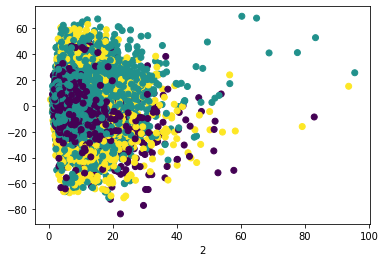

In [50]:
# kmeans - 3 küme
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train1)
labels = kmeans.predict(X_train1)

plt.scatter(X_train1['ind_14'],X_train1['ind_176'],c = labels)
plt.xlabel('1')
plt.xlabel('2')
plt.show()

In [79]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2]
 [2906 8719 6285]]


In [115]:
cleanup_nums = {'BUY':1,'SELL':2,'NONE':0}
y_cluster = y_train.replace(cleanup_nums)
y_cluster.head

<bound method NDFrame.head of        0
2001   1
2002   1
2003   1
2004   1
2005   1
...   ..
25623  2
25624  2
25625  2
25626  2
25627  2

[17910 rows x 1 columns]>

In [116]:
(y_cluster[0] == labels).value_counts()

False    10742
True      7168
Name: 0, dtype: int64

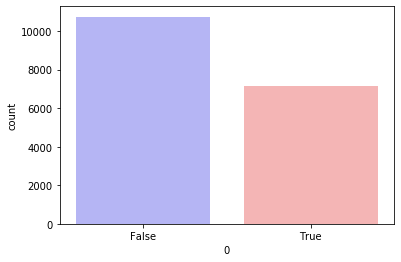

In [118]:
sns.countplot((y_cluster[0] == labels), palette="bwr")

In [128]:
# kmeans random forest verisi ile
X_train2, X_test2, y_train, y_test = splitting(X1_2, y, 0.10)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_train2)
labels1 = kmeans.predict(X_train2)
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2]
 [7404 5006 5500]]


In [129]:
cleanup_nums = {'BUY':2,'SELL':1,'NONE':0}
y_cluster = y_train.replace(cleanup_nums)
(y_cluster[0] == labels1).value_counts()

False    12322
True      5588
Name: 0, dtype: int64

In [130]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train2)
labels2 = kmeans.predict(X_train2)
unique_elements, counts_elements = np.unique(labels2, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [9252 8658]]


In [131]:
a = ( labels1 == labels2)
unique_elements, counts_elements = np.unique(a, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [9152 8758]]
